In [69]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
from collections import Counter
from scipy.stats import wasserstein_distance
from itertools import combinations
from tqdm import tqdm

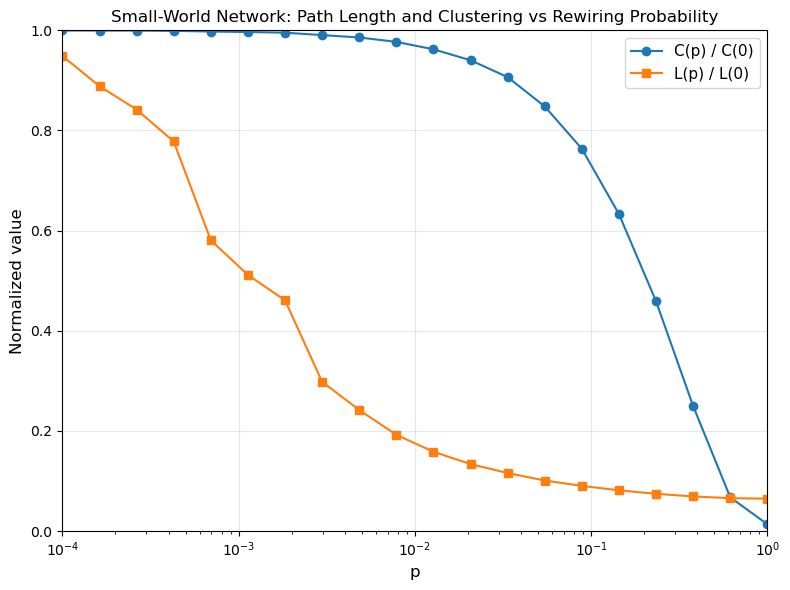

In [ ]:
# 1

# getting L(0) and C(0)
normalizer = nx.watts_strogatz_graph(1000, 10, 0)
C0 = nx.average_clustering(normalizer)
L0 = nx.average_shortest_path_length(normalizer)

# storage for trials
pspace = np.logspace(-4, 0, 20)
cdict = {p: [] for p in pspace}
ldict = {p: [] for p in pspace}

for i in range(1, 21): # all trials to average over
    for p in pspace: # getting correct p values
        G = nx.watts_strogatz_graph(1000, 10, p)
        # create lists of values and store as value in dicts
        cdict[p].append(nx.average_clustering(G) / C0)
        ldict[p].append(nx.average_shortest_path_length(G) / L0)

# list of averaged values
cvals = [np.mean(cdict[p]) for p in pspace]
lvals = [np.mean(ldict[p]) for p in pspace]
# list of p values
pvals = list(pspace)

# plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(pvals, cvals, 'o-', label='C(p) / C(0)', markersize=6)
ax.plot(pvals, lvals, 's-', label='L(p) / L(0)', markersize=6)

ax.set_xscale('log')
ax.set_xlabel('p', fontsize=12)
ax.set_ylabel('Normalized value', fontsize=12)
ax.set_xlim(1e-4, 1)
ax.set_ylim(0, 1)
ax.legend(fontsize=11)
ax.set_title('Small-World Network: Path Length and Clustering vs Rewiring Probability')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'.\imgs\watts_strogatz_figure2.png', dpi=150)
plt.show()

In [ ]:
# 3i

def ba_generator(N, m, plot=None):
    '''
    Implements Barabasi-Albert graph generation method, beginning with a complete
    graph of size 4
    
    :param N (int): Size of resulting network
    :param m (int): Number of new nodes to connect to at each time step
    :param plot (string): Name of file or else will not plot figure

    returns: G (nx.Graph): Generated network
    '''
    G = nx.complete_graph(4)

    # create list of nodes and make them repeat the same number of times as their degree
    attachment_pool = []
    for node, deg in G.degree():
        attachment_pool.extend([node] * deg)

    for i in range(4,N): # started with 4 nodes
        # pick m targets from pool (more entries for higher-degree nodes)
        selected_nodes = random.sample(attachment_pool, m)
        
        G.add_node(i) # named so that it doesn't overwrite itself
        for s_node in selected_nodes:
            G.add_edge(i, s_node)
            # update pool
            attachment_pool.append(i)
            attachment_pool.append(s_node)
        
    if plot != None:
        # plot distribution
        plt.figure(figsize=(10,6))
        degrees = [val for (node, val) in G.degree()] # list of degrees
        distplot = sns.displot(degrees, discrete=True)
        plt.xlim(min(degrees), None)
        plt.savefig(f'.\\imgs\\{plot}.png', dpi=150)

    return G

ten_two = ba_generator(pow(10, 2), 4, plot="100dist")
ten_three = ba_generator(pow(10, 3), 4, plot='1000dist')
ten_four = ba_generator(pow(10, 4), 4, plot='10000dist')

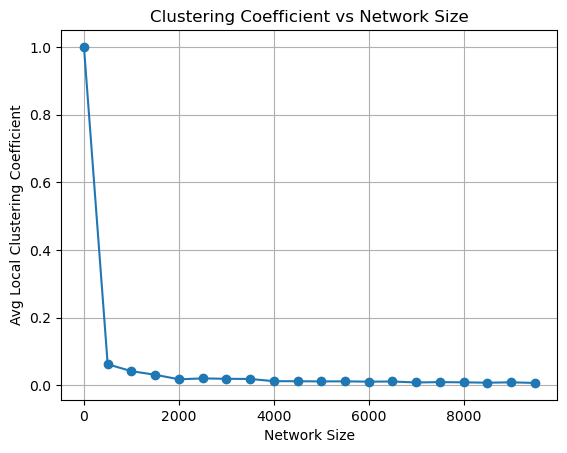

In [49]:
# 3iii

Ns = []
clustering_vals = []

for N in range(1, 10000, 500):
    G = ba_generator(N, 4)
    clustering_vals.append(nx.average_clustering(G))
    Ns.append(N)

plt.plot(Ns, clustering_vals, marker='o')
plt.xlabel('Network Size')
plt.ylabel('Avg Local Clustering Coefficient')
plt.title('Clustering Coefficient vs Network Size')
plt.grid(True)
plt.savefig(r'.\imgs\clustering_vs_size.png')
plt.show()

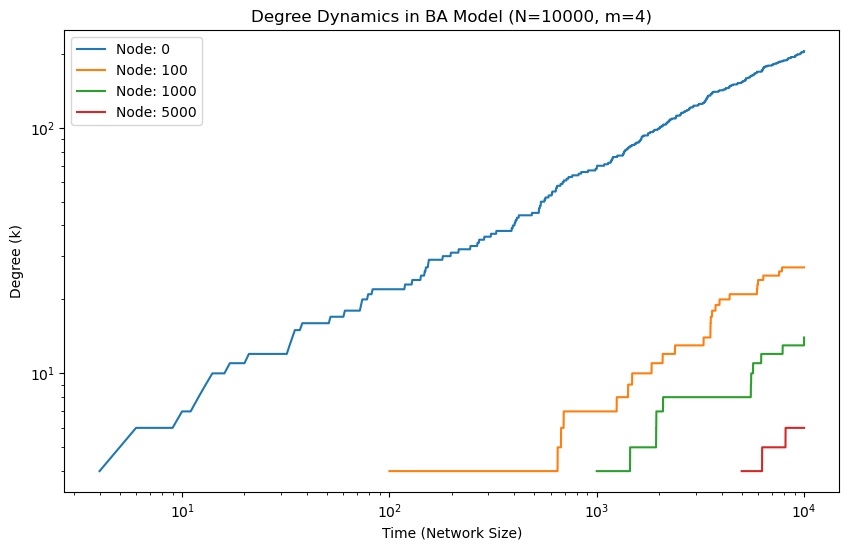

In [ ]:
# 3iv

def ba_tracker(N, m):
    '''
    Implements Barabasi-Albert model while tracking the evolution of specific nodes 
    (at t=1, 100, 1000, and 5000) as graph expands
    
    :param N (int): Size of resulting network
    :param m (int): Number of new nodes to connect to at each time step
    '''
    G = nx.complete_graph(4)

    # dict of nodes to track and list of their values
    tracking_dict = {0:[], 100:[], 1000:[], 5000:[]}

    # create list of nodes and make them repeat the same number of times as their degree
    attachment_pool = []
    for node, deg in G.degree():
        attachment_pool.extend([node] * deg)

    size = len(G.nodes())
    t = 0 # init time counter

    while size < N:
        # pick m targets from pool (more entries for higher-degree nodes)
        selected_nodes = random.sample(attachment_pool, m)

        G.add_node(size)

        for s_node in selected_nodes:
            G.add_edge(size, s_node)
            # update pool
            attachment_pool.append(size)
            attachment_pool.append(s_node)

        # updating dict
        for node in tracking_dict:
            if G.has_node(node):
                tracking_dict[node].append(G.degree(node))
            else:
                tracking_dict[node].append(None) # not "born" yet
 
        size += 1
        t += 1

    # plotting
    plt.figure(figsize=(10, 6))
    
    for node, history in tracking_dict.items():
        # filter out values for nodes not yet created
        clean_history = [h for h in history if h is not None]
        # x axis is the time step where the node was active
        time_axis = range(N - len(clean_history), N)
        
        plt.plot(time_axis, clean_history, label=f'Node: {node}')

    plt.title(f"Degree Dynamics in BA Model (N={N}, m={m})")
    plt.xlabel("Time (Network Size)")
    plt.ylabel("Degree (k)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig(r'./imgs/degree_dynamics.png')

ba_tracker(10000, 4)

In [ ]:
# 3b optimization model creation

def o_model(N, delta):
    ''' 
    Implements optimization model for generating scale-free networks

    Args:
    N (int): Number of nodes in the final network. Also determines the number of timesteps
    delta (float or int): Cost-per-distance parameter

    Returns:
    G (nx.Graph): Generated network
    '''
    G = nx.Graph()
    G.add_node(0, loc=(.5,.5)) # root at center

    path_lengths = {0: 0} # store path lengths from root (dist 0 from itself)
    locs = {0: (0.5, 0.5)} # pre-allocate location storage
    
    for i in range(1,N):
        new_loc = (random.random(), random.random())
        locs[i] = new_loc
        G.add_node(i, loc=new_loc)
        # finding minimum of cost function
        target = min(range(i), key=lambda j: (delta * math.dist(new_loc, locs[j])) + path_lengths[j])
        G.add_edge(i, target)
        path_lengths[i] = path_lengths[target] + 1 # update path length 

    return G
        
point1 = o_model(1000, .1)
ten = o_model(1000, 10)
thousand = o_model(1000, 1000)

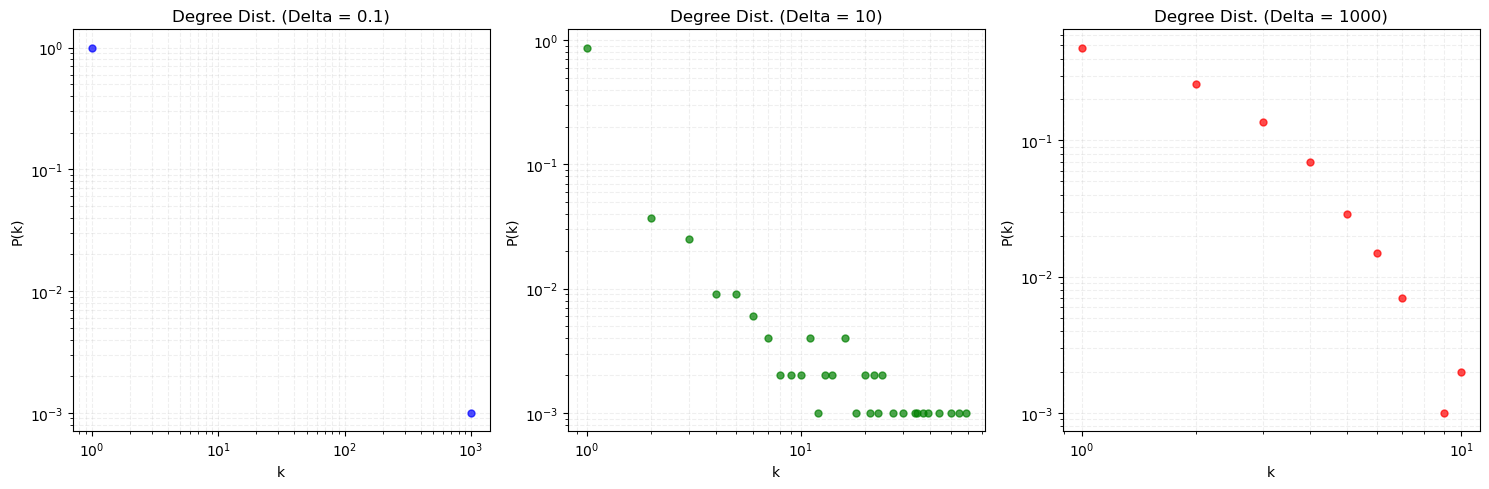

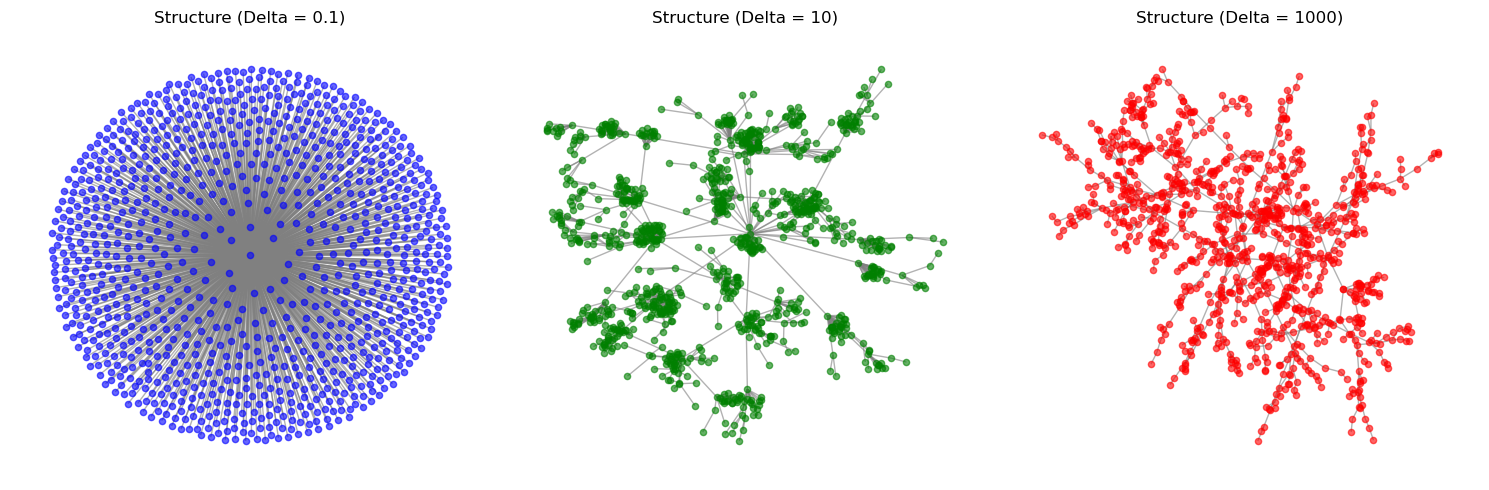

In [34]:
# 3c degree distribution plots

def plot_degree_distributions(graphs, labels):
    plt.figure(figsize=(15, 5))
    
    colors = ['blue', 'green', 'red']
    
    for i, (G, label) in enumerate(zip(graphs, labels)):
        plt.subplot(1, 3, i+1)
        
        # get degrees and calculate distribution
        degrees = [d for n, d in G.degree()]
        
        # count of each unique degree-value
        k_values, counts = np.unique(degrees, return_counts=True)
        
        # normalize counts to get P(k)
        Pk = counts / sum(counts)
        
        # log-log scale
        plt.loglog(k_values, Pk, 'o', color=colors[i], markersize=5, alpha=0.7)
        
        # formatting
        plt.title(f"Degree Dist. (Delta = {label})")
        plt.xlabel("k")
        plt.ylabel("P(k)")
        plt.grid(True, which="both", ls="--", alpha=0.2)
        
    plt.tight_layout()
    plt.savefig(r'.\imgs\o_model_degdist.png')
    plt.show()

def visualize_o_model(graphs, labels):
    plt.figure(figsize=(15, 5))

    colors = ['blue', 'green', 'red']

    for i, (G, label) in enumerate(zip(graphs, labels)):
        plt.subplot(1, 3, i+1)

        nx.draw(G, node_color=colors[i], node_size=20, edge_color='gray', alpha=0.6)
        plt.title(f"Structure (Delta = {label})")

    plt.tight_layout()
    plt.savefig(r'.\imgs\optimization_netviz.png')


graphs_list = [point1, ten, thousand]
labels_list = [0.1, 10, 1000]

plot_degree_distributions(graphs_list, labels_list)
visualize_o_model(graphs_list, labels_list)

In [50]:
# 3d link-selection and copying

def ls_model(N):
    '''
    Implements link selection model for generating scale-free networks

    Args:
        N (int): Size of resulting network as well as number of timesteps

    Returns:
        G (nx.Graph): Generated network
    '''
    G = nx.complete_graph(2)

    for i in range(2,N):
        G.add_node(i)
        u, v = random.choice(list(G.edges()))
        target = random.choice([u, v])
        G.add_edge(i, target)
    return G    

def c_model(N, p):
    ''' 
    Implements copying model for generating scale-free networks

    Args:
        N (int): Size of resulting network as well as number of timesteps
        p (float): Probability of connecting to target directly vs one of its neighbors

    Returns:
        G (nx.Graph): Generated network
    '''
    G = nx.complete_graph(2)

    for i in range(2,N):
        G.add_node(i)
        target = random.randint(0, i -1) # to speed it up
        if random.random() < p:
            G.add_edge(i, target)
        else:
            nbrs = list(G.neighbors(target))
            if nbrs:
                target_neighbor = random.choice(nbrs)
                G.add_edge(i, target_neighbor)
            else:
                G.add_edge(i, target)
    return G

<>:165: SyntaxWarning: invalid escape sequence '\P'
<>:170: SyntaxWarning: invalid escape sequence '\P'
<>:182: SyntaxWarning: invalid escape sequence '\s'
<>:165: SyntaxWarning: invalid escape sequence '\P'
<>:170: SyntaxWarning: invalid escape sequence '\P'
<>:182: SyntaxWarning: invalid escape sequence '\s'
C:\Users\User\AppData\Local\Temp\ipykernel_17612\1674738841.py:165: SyntaxWarning: invalid escape sequence '\P'
  ax.loglog(ks, pi_ks, 'o', alpha=0.6, label='Measured $\Pi(k)$')
C:\Users\User\AppData\Local\Temp\ipykernel_17612\1674738841.py:170: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel('$\Pi(k)$', fontsize=12)
C:\Users\User\AppData\Local\Temp\ipykernel_17612\1674738841.py:182: SyntaxWarning: invalid escape sequence '\s'
  ax.loglog(ref_x, ref_y, 'k--', alpha=0.3, label='Linear $\sim k$')


Chosen Model: Barabasi-Albert
Chosen Model: Optimization
Chosen Model: Link Selection
Chosen Model: Copying


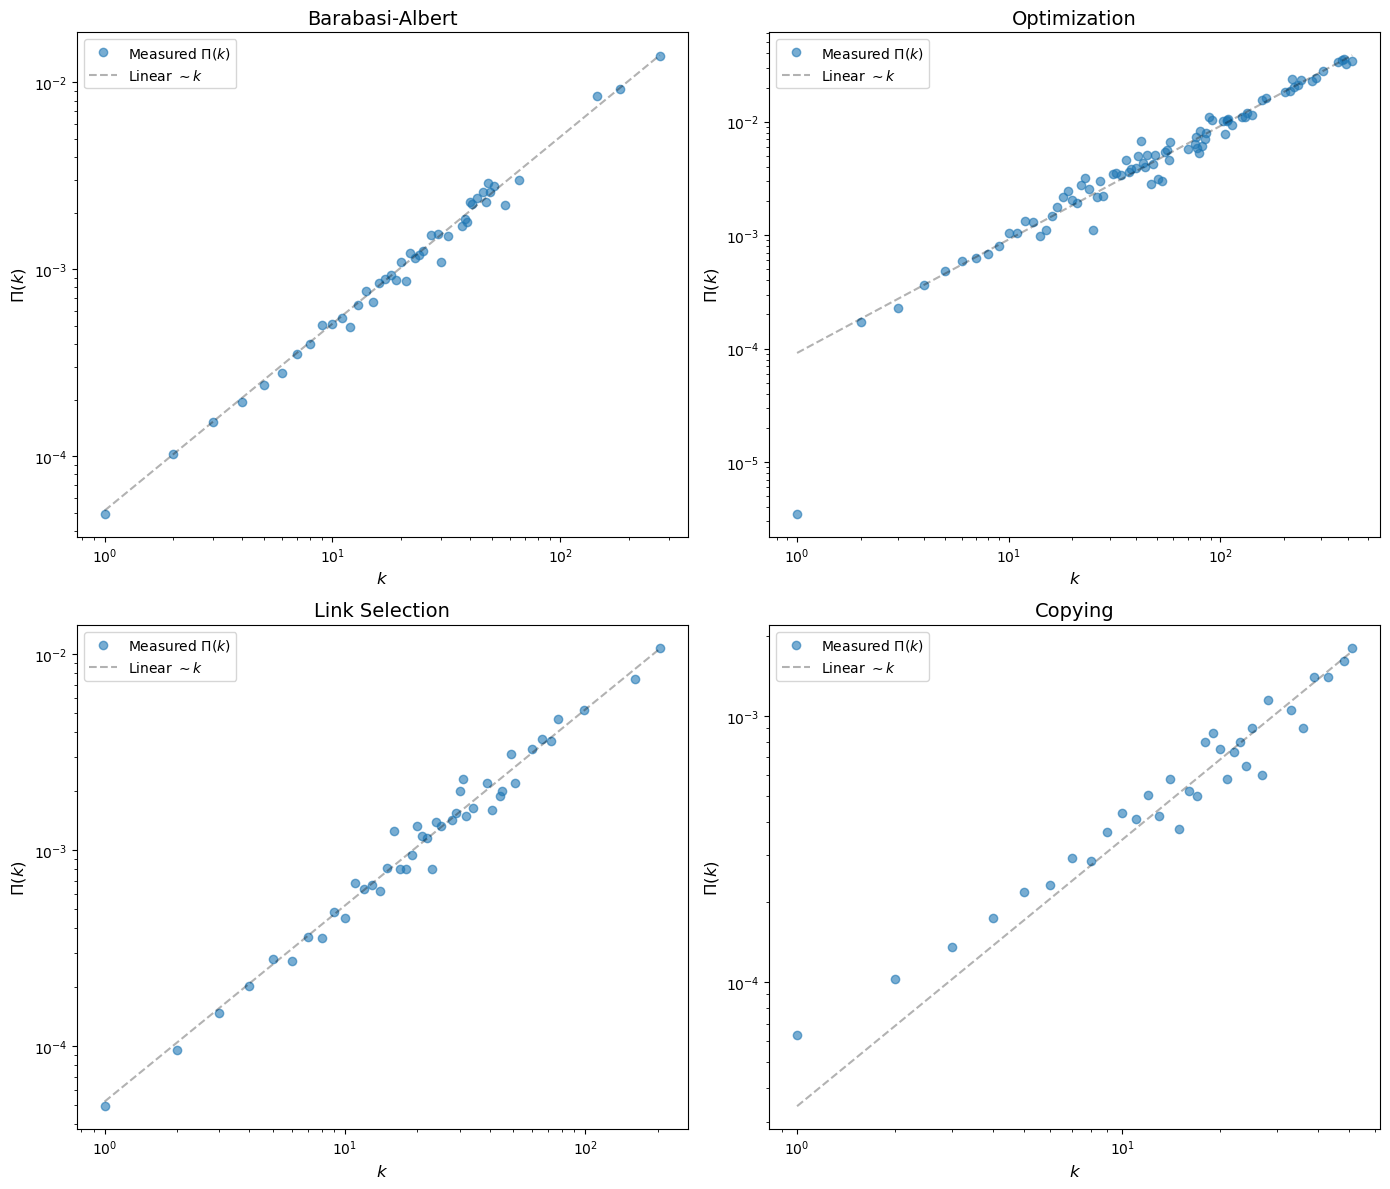

In [ ]:
# 3e pi(k) plots

def measure_pref_attachment(G, iter, m=None, delta=None, p=None):
    '''
    Measures the probability pi(k) of a new node connecting to a node of degree k 
    given network generated from one of four models -- Barabasi-Albert, Optimization,
    Link Selection, or Copying. To run for a particular model, include that model's parameter
    (make sure others are None); otherwise, defaults to Link Selection
    
    Args:
        G (nx.Graph): Generated network. Must be named according to the generation procedure (ba, o, ls, c)
        iter (int): Number of trials
        m (int, optional): "m" parameter for ba model
        delta (float or int, optional): "delta" parameter for optimization model
        p (float, optional): "p" parameter for copying model

    Returns:
        degprobs (dict): Dictionary mapping k to pi(k)
    '''
    counter = 0 # counter for trials
    observations = [] # result tracker

    if m:
        print("Chosen Model: Barabasi-Albert")
        degree_counts = Counter(d for n, d in G.degree())

        # for creation logic
        attachment_pool = []
        for node, deg in G.degree():
            attachment_pool.extend([node] * deg)

        while counter < iter:
            # copy creation logic to find node that it would have connected to
            target = random.sample(attachment_pool, m)[0]
            # find degree and append
            k = G.degree(target)
            observations.append(k)
            counter += 1
        # create dict by iterating through observations and dividing the count of deg k by len(observations),
        # then dividing by degree_counts[k]
        degprobs = {}
        # iterate only through unique degrees found
        obs_counts = Counter(observations)
        for k in obs_counts:
            pi_k = (obs_counts[k] / len(observations)) / degree_counts[k]
            degprobs[k] = pi_k
        return degprobs
    
    elif delta:
        print("Chosen Model: Optimization")
        degree_counts = Counter(d for n, d in G.degree())

        # pre-calculating path lengths and pre-fetching locations to improve performance
        root_node = 0
        path_lengths = nx.single_source_shortest_path_length(G, root_node)
        locs = nx.get_node_attributes(G, 'loc')

        # helper function
        def cost(i, j):
            dist = math.dist(locs[i], locs[j])
            return (delta * dist) + path_lengths[j]
        
        while counter < iter:
            # copy creation logic to find node that it would have connected to
            new_loc = (random.random(), random.random())
            locs['new'] = new_loc
            G.add_node('new', loc=new_loc)
            target = min(path_lengths, key=lambda j: cost('new', j)) # iterate over path_lengths to check only existing nodes
            # find degree and append
            k = G.degree(target)
            observations.append(k)
            counter += 1
        # create dict by iterating through observations and dividing the count of deg k by len(observations),
        # then dividing by degree_counts[k]
        degprobs = {}
        # iterate only through unique degrees found
        obs_counts = Counter(observations)
        for k in obs_counts:
            pi_k = (obs_counts[k] / len(observations)) / degree_counts[k]
            degprobs[k] = pi_k
        return degprobs
    
    elif p:
        print("Chosen Model: Copying")
        degree_counts = Counter(d for n, d in G.degree())
        while counter < iter:
            # copy creation logic to find node that it would have connected to
            source = random.choice(list(G.nodes()))
            if random.random() < p:
                target = source
            else:
                target = random.choice(list(G.neighbors(source)))
            # find degree and append
            k = G.degree(target)
            observations.append(k)
            counter += 1
        # create dict by iterating through observations and dividing the count of deg k by len(observations),
        # then dividing by degree_counts[k]
        degprobs = {}
        # iterate only through unique degrees found
        obs_counts = Counter(observations)
        for k in obs_counts:
            pi_k = (obs_counts[k] / len(observations)) / degree_counts[k]
            degprobs[k] = pi_k
        return degprobs
    
    else:
        print("Chosen Model: Link Selection")
        degree_counts = Counter(d for n, d in G.degree())
        while counter < iter:
            # copy creation logic to find node that it would have connected to
            u, v = random.choice(list(G.edges()))
            target = random.choice([u, v])
            # find degree and append
            k = G.degree(target)
            observations.append(k)
            counter += 1
        # create dict by iterating through observations and dividing the count of deg k by len(observations),
        # then dividing by degree_counts[k]
        degprobs = {}
        # iterate only through unique degrees found
        obs_counts = Counter(observations)
        for k in obs_counts:
            pi_k = (obs_counts[k] / len(observations)) / degree_counts[k]
            degprobs[k] = pi_k
        return degprobs

# plotting function
def plot_pref_attachment(N=10000, m=1, delta=10, p=.5): # p not specified so going with 0.5
    fig, ax = plt.subplots(2, 2, figsize=(14,12))
    ax = ax.flatten()

    ba = ba_generator(N, m)
    o = o_model(N, delta)
    ls = ls_model(N)
    c = c_model(N, p)
    graphs = [ba, o, ls, c]

    # string names to label the plots and identifying keys
    names = ['Barabasi-Albert', 'Optimization', 'Link Selection', 'Copying']

    results_dict = {} # dict to store results

    for i, G in enumerate(graphs):
        name = names[i]
        if name == 'Barabasi-Albert':
            degprobs = measure_pref_attachment(G, N, m=m)
        elif name == 'Optimization':
            degprobs = measure_pref_attachment(G, N, delta=delta)
        elif name == 'Link Selection':
            degprobs = measure_pref_attachment(G, N)
        elif name == 'Copying':
            degprobs = measure_pref_attachment(G, N, p=p)
        results_dict[names[i]] = degprobs

    # plotting
    for i, (name, ax) in enumerate(zip(names, ax)):
        data = results_dict.get(name, {})

        # extract k and pi(k)
        ks = list(data.keys())
        pi_ks = list(data.values())

        # create plot
        ax.loglog(ks, pi_ks, 'o', alpha=0.6, label='Measured $\Pi(k)$')

        # formatting
        ax.set_title(name, fontsize=14)
        ax.set_xlabel('$k$', fontsize=12)
        ax.set_ylabel('$\Pi(k)$', fontsize=12)
        
        # generate theoretical linear reference line
        min_k, max_k = min(ks), max(ks)
        ref_x = np.linspace(min_k, max_k, 100)
        # normalize so it passes through the middle of the cloud
        mid_y = sum(pi_ks)/len(pi_ks)
        mid_x = sum(ks)/len(ks)
        ref_y = ref_x * (mid_y / mid_x) 
        # dashed black line
        ax.loglog(ref_x, ref_y, 'k--', alpha=0.3, label='Linear $\sim k$')

        ax.legend()

    plt.tight_layout()
    plt.savefig(r'.\imgs\pref_attachment.png')
    plt.show()

plot_pref_attachment()

In [71]:
# 4c graph distance implementation

def descriptor(G):
    '''
    Takes graph G as input and returns a tuple of lists for harmonic, betweenness,
    eigenvector, and degree centrality values
    '''
    h = list(nx.harmonic_centrality(G).values())
    bc = list(nx.betweenness_centrality(G, k=50).values()) # using k=50 to speed things up
    eig = list(nx.eigenvector_centrality(G).values())
    deg = list(nx.degree_centrality(G).values())

    return (h, bc, eig, deg)

def distance(G1, G2):
    ''' 
    Takes two graphs as input and returns the average of the Wasserstein distances
    between their centrality distributions
    '''
    vals_a = descriptor(G1)
    vals_b = descriptor(G2)

    dists = [
        wasserstein_distance(u, v) 
        for u, v in zip(vals_a, vals_b)
    ]
    
    return np.mean(dists)

100%|██████████| 1000/1000 [09:48<00:00,  1.70it/s]


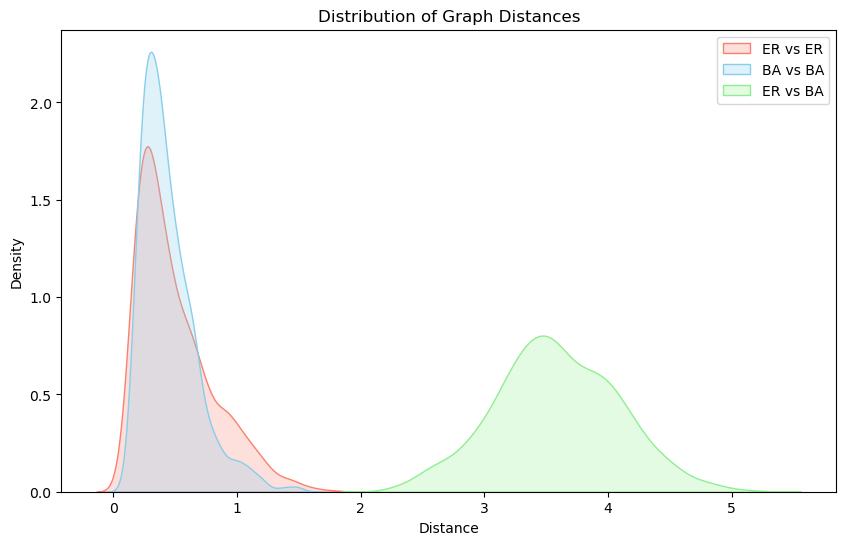

In [72]:
# 4d/e/f sampling

# erdos-renyi
er_distances = []
for t in tqdm(range(1000)): # tracking progress since this takes a while
    er1 = nx.erdos_renyi_graph(500, .016)
    er2 = nx.erdos_renyi_graph(500, .016)
    dist = distance(er1, er2)
    er_distances.append(dist)

# barabasi-albert
ba_distances = []
for t in tqdm(range(1000)):
    ba1 = nx.barabasi_albert_graph(500, 4)
    ba2 = nx.barabasi_albert_graph(500, 4)
    dist = distance(ba1, ba2)
    ba_distances.append(dist)

# one of each
between_distances = []
for t in tqdm(range(1000)):
    er = nx.erdos_renyi_graph(500, .016)
    ba = nx.barabasi_albert_graph(500, 4)
    dist = distance(er, ba)
    between_distances.append(dist)

# creating plot
plt.figure(figsize=(10, 6))

sns.kdeplot(er_distances, fill=True, label='ER vs ER', color='salmon')
sns.kdeplot(ba_distances, fill=True, label='BA vs BA', color='skyblue')
sns.kdeplot(between_distances, fill=True, label='ER vs BA', color='lightgreen')

plt.title('Distribution of Graph Distances')
plt.xlabel('Distance')
plt.legend()
plt.savefig(r'.\imgs\graph_distances.png')
plt.show()

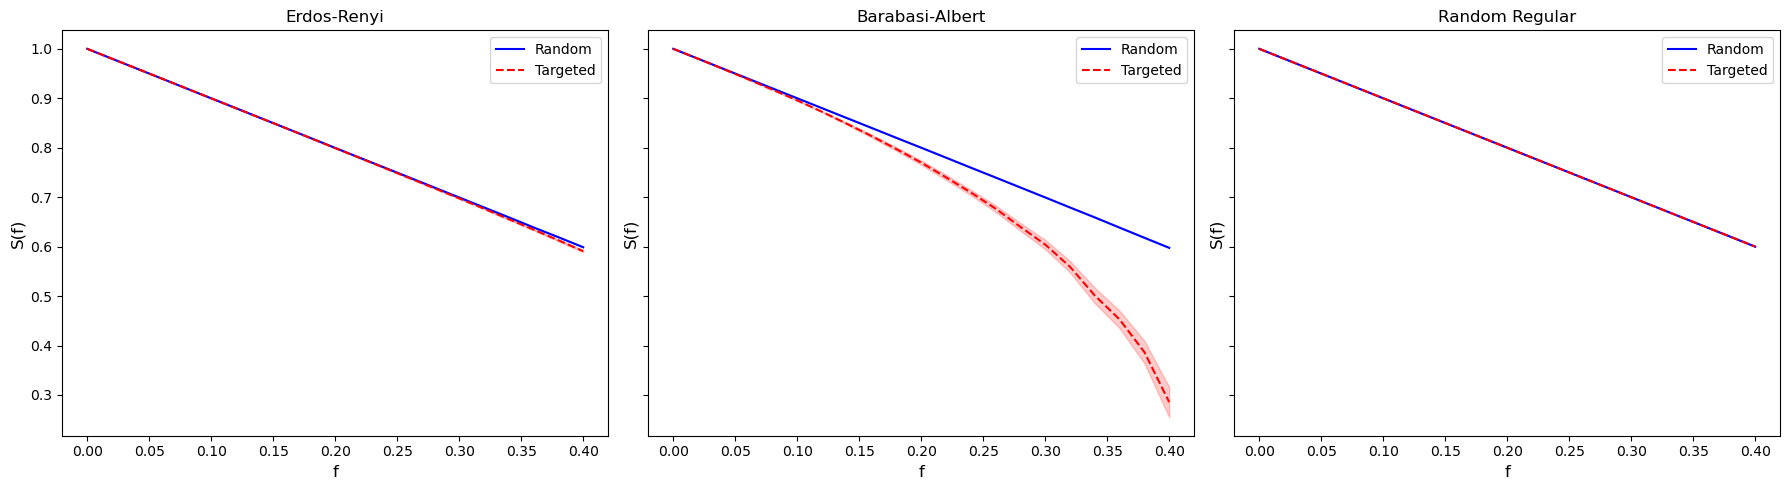

In [78]:
# 5

er_graphs = []
for t in range(10):
    t = nx.erdos_renyi_graph(5000, .002)
    er_graphs.append(t)

ba_graphs = []
for t in range(10):
    t = nx.barabasi_albert_graph(5000, 5)
    ba_graphs.append(t)

reg_graphs = []
for t in range(10):
    t = nx.random_regular_graph(10, 5000)
    reg_graphs.append(t)

def attacker(graphlist, N):
    '''
    Simulates attacks on networks with random and targeted removal on proportions from 
    0.02 to 0.4% in increments of 0.02; returns lists of dicts mapping graph IDs to fraction
    removed and relative size of largest connected component
    
    graphlist (list): List of networks to be attacked
    N (int): Size of networks
    '''
    results_random = []
    for i, g in enumerate(graphlist): # enumerate to track which graph is which
        for f in np.arange(0, 0.42, 0.02):
            G = g.copy()
            num_to_remove = int(N*f)
            chopping_block = random.sample(list(G.nodes()), num_to_remove)
            G.remove_nodes_from(chopping_block)
            gcc_size = len(max(nx.connected_components(G), key=len))
            S_f = gcc_size / N

            # record results
            results_random.append({
            'graph_id': i,
            'fraction_removed': round(f, 2),
            'robustness': S_f
        })

    results_targeted = []
    for i, g in enumerate(graphlist):
        for f in np.arange(0, 0.42, 0.02):
            G = g.copy()
            num_to_remove = int(N*f)

            # sort by descending order of degree and slice the top N
            nodes_sorted = sorted(G.degree(), key=lambda x: x[1], reverse=True)
            chopping_block = [node for node, degree in nodes_sorted[:num_to_remove]]

            G.remove_nodes_from(chopping_block)
            gcc_size = len(max(nx.connected_components(G), key=len))
            S_f = gcc_size / N

            results_targeted.append({
            'graph_id': i,
            'fraction_removed': round(f, 2),
            'robustness': S_f
        })

    return results_random, results_targeted

# --- plot ---

# run simulations
er_rand, er_targ = attacker(er_graphs, 5000)
ba_rand, ba_targ = attacker(ba_graphs, 5000)
reg_rand, reg_targ = attacker(reg_graphs, 5000)

# helper to process data
def get_stats(data_list):
    df = pd.DataFrame(data_list)
    # get mean and std dev of S(f)
    return df.groupby('fraction_removed')['robustness'].agg(['mean', 'std'])

# creating plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
ensembles = [
    ('Erdos-Renyi', er_rand, er_targ, ax[0]),
    ('Barabasi-Albert', ba_rand, ba_targ, ax[1]),
    ('Random Regular', reg_rand, reg_targ, ax[2])
]

for name, rand_data, targ_data, ax in ensembles:
    # run helper
    stats_r = get_stats(rand_data)
    stats_t = get_stats(targ_data)
    
    # plot random as solid line
    ax.plot(stats_r.index, stats_r['mean'], label='Random', color='blue')
    ax.fill_between(stats_r.index, 
                    stats_r['mean'] - stats_r['std'], 
                    stats_r['mean'] + stats_r['std'], alpha=0.2, color='blue')
    
    # plot targeted as dashed line
    ax.plot(stats_t.index, stats_t['mean'], label='Targeted', linestyle='--', color='red')
    ax.fill_between(stats_t.index, 
                    stats_t['mean'] - stats_t['std'], 
                    stats_t['mean'] + stats_t['std'], alpha=0.2, color='red')
    
    ax.set_title(name)
    ax.set_xlabel('f', fontsize=12)
    ax.set_ylabel('S(f)', fontsize=12)
    ax.legend()

plt.tight_layout()
plt.savefig(r'.\imgs\attacks.png')
plt.show()